<a href="https://colab.research.google.com/github/mknomics/soda/blob/main/Elasticity_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SODA DATA
This dataset contains product level montly data for multiple stores and products within Greece.  


**IMPORTANT DISCLAIMER**  I use this dataset to do a naive estimation of various demand equations BUT doing so is hazardously wrong in practice.  Why? The Data points in this set are the result of an interaction of BOTH supply AND demand.  Our interpretation of Demand is "willingness-to-pay".  A true demand schedule is more properly represented in the [Google Sheet](https://docs.google.com/spreadsheets/d/1w5R60JGle5JAWz_wFuQ7dutR948jm60gSvcUTqK2UUI/edit?usp=sharing) that we completed in class.  

A more robust estimation would use causal analysis and other experimental methods not covered here. 

## Import Packages


In [1]:
import pandas as pd  #pandas is good for data manipulation.  I rename it here as "pd" to make it easier to call in the script below.  I could rename it anything I want but "pd" is standard
import matplotlib.pyplot as plt #matplotlib is a good package for graphing.  Again, I rename it plt to make coding more simple
import numpy as np #numpy is a good package for doing calculations
from sklearn.linear_model import LinearRegression  #sklearn is a package that is good at estimation.  Tons of models are available and here I import LinearRegression because that's all I need




## Get Some Data

In [2]:

#Import a csv file from a target url:  What is a csv file?  Go to the url below to see the raw data.  columns are separated by a "," and the last column lacks a ","
data_url='https://raw.githubusercontent.com/mknomics/soda/main/soda.csv' # I define a string variable using apostrophe ' but I could ahve also used quotes " ".  I just cannot mix apostophe and quotes in the same line
df = pd.read_csv(data_url) # This line creates a pandas DataFrame that I defined as "df".  I could have called it anything I want

# Set my date objects.  This must be done so that 'date' is recognized as a date and not just a random string variable
df['date']=pd.to_datetime(df['date']) #make date a datetime object
df['year']=pd.DatetimeIndex(df['date']).year # I define a variable 'year' using the DatetimeIndex method
df['month']=pd.DatetimeIndex(df['date']).month # similarly I repeat and define 'month'



### Look at Data (below) df.head()
### What are the levels of variation?
1) time (month, year)

2) geography (city)

3) Store (shop, latitude, longitude)

4) Brand

5) Container (equivalent to capacity)


In [3]:
df.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity,year,month
0,1222,2013-02-28,Athens,37.96245,23.68708,671022,shop_3,adult-cola,plastic,1.5lt,2.46,10709,2013,2
1,1256,2013-02-28,Athens,37.97945,23.71622,671022,shop_1,adult-cola,plastic,1.5lt,1.91,12703,2013,2
2,2325,2014-02-28,Athens,37.97945,23.71622,668203,shop_1,adult-cola,plastic,1.5lt,3.99,3642,2014,2
3,2333,2014-02-28,Athens,37.96245,23.68708,668203,shop_3,adult-cola,plastic,1.5lt,2.82,9282,2014,2
4,3334,2015-02-28,Athens,37.97945,23.71622,667237,shop_1,adult-cola,plastic,1.5lt,1.29,15782,2015,2


In [4]:
pd.crosstab(df['city'],df['shop'])

shop,shop_1,shop_2,shop_3,shop_4,shop_5,shop_6
city,,,,,,
Athens,1260,0,1260,0,0,0
Irakleion,0,1260,0,0,0,0
Larisa,0,0,0,0,1260,0
Patra,0,0,0,0,0,1260
Thessaloniki,0,0,0,1260,0,0


### Interpret dataset
Each line represents the montly sales volume and average price for a specific brand/bottle type of cola that was sold in a specific store within Greece 




### Descriptive Statistics


In [5]:

print("There are " + str(df[['id']].nunique()[0]) + " unique shops in this dataset")
df.describe()

There are 7560 unique shops in this dataset


,id,lat,long,pop,price,quantity,year,month
count,7560.00000,7501.000000,7501.000000,7560.000000,7560.000000,7560.000000,7560.000000,7560.000000
mean,3779.50000,38.300808,23.270191,355174.095238,1.196049,29421.715212,2015.000000,6.500000
std,2182.52835,1.650503,1.087175,232441.012350,0.816838,17665.033867,2.000132,3.452281
min,0.00000,35.327870,21.734440,134219.000000,0.110000,2953.000000,2012.000000,1.000000
25%,1889.75000,37.962450,22.417610,141732.000000,0.620000,16572.750000,2013.000000,3.750000
50%,3779.50000,38.244440,22.930860,257501.500000,0.930000,25312.000000,2015.000000,6.500000
75%,5669.25000,39.636890,23.716220,665102.000000,1.510000,37751.500000,2017.000000,9.250000
max,7559.00000,40.643610,25.143410,672130.000000,4.790000,145287.000000,2018.000000,12.000000


##**City-Product-Time Level Analysis**
Let's look at data at the city-product-time level.  There will be variation on the following dimensions:

*   Between Products
*   Over Time
*   Between cities



In [6]:
#Step 1: use groupby method and define a new dataframe for each of the metrics that we are interested in
df_mean_Q = df.groupby(['brand','container','city','date'])['quantity'].mean().reset_index()# I reset the index for each new data set.  Don't worry if the indexing is confusing since it isn't the main point here
df_mean_P = df.groupby(['brand','container','city','date'])['price'].mean().reset_index()
# Step 2: the data frames from Step #1 can be merged by their unique rows.  Rows are unique by city x brand x container x date
df_city = pd.merge(df_mean_Q, df_mean_P) # merges df_total_Q dataframe with df_mean_P dataframe based on their unique rows

# Now let's rename the price and quantity column so we don't get confused later about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) # I 

# we lost our columns df['year'] and df['month'] so lets add these back
df_city['year']=pd.DatetimeIndex(df_city['date']).year # I define a variable 'year' using the DatetimeIndex method
df_city['month']=pd.DatetimeIndex(df_city['date']).month # similarly I repeat and define 'month'about what we are looking at
df_city.rename(columns={'quantity': 'mean_q', 'price': 'mean_p'},inplace=True) 

df_city = df_city.pivot(index='date', columns=['city','brand','container'], values=['mean_q','mean_p'])


### Hierarchical Columns
Now my columns in df_city are labeled in a hierarchy as follows

df_city[METRIC][CITY][BRAND][CONTAINER]

**METRIC** is in [mean_q, mean_p]

**CITY** is in ['Athens', 'Irakleion', 'Larisa', 'Patra', 'Thessaloniki']

**BRAND** is in ['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost',  'orange-power']

**CONTAINER** is in ['plastic', 'can', nan, 'glass']

In [7]:
# Example: the mean price of adult-cola can in Athens is:
df_city['mean_p']['Athens']['adult-cola']['can']

date
2012-01-31    0.550
2012-02-29    0.390
2012-03-31    0.740
2012-04-30    0.815
2012-05-31    0.765
              ...  
2018-08-31    0.630
2018-09-30    0.560
2018-10-31    0.725
2018-11-30    0.590
2018-12-31    0.685
Name: can, Length: 84, dtype: float64

## Athens Function 
Within a city, we can define both price and quantity by specifying the brand and container.

---
Let's define a simple function to compare products in Athens using a scatter plot.  Quantity and Price are defined by brand and container.  Thus our function will take on 4 variables, 

2 inputs define which quantity we want

1.   Q_brand
2.   Q_container

2 inputs define which price we want
1.   P_brand
2.   P_container

Our new function Athens takes these inputs and returns the associated scatter plot

**EXAMPLE:**  a scatter of the price of adult-cola cans and the quanity of orange-power cans would be:

**Athens(Q_brand='orange-power', Q_container='can', P_brand='adult-cola', P_container='can')**

Remember:


**BRAND** is in ['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost',  'orange-power']

**CONTAINER** is in ['plastic', 'can', nan, 'glass']

In [8]:

def Athens(Q_brand=True, Q_container=True, P_brand=True, P_container=True):

 # define independent variable X
  X = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Y = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)

  linear_regression = LinearRegression() # Create a linear_regression object
  linear_regression.fit(X , Y)  # Fit the model
  Y_pred = linear_regression.predict(X)  # Fits the Data Points "X" with the parameters from the Fit step to form a prediction

  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')


  #plt.scatter( df_city['mean_p']['Athens'][P_brand][P_container], df_city['mean_q']['Athens'][Q_brand][Q_container])
  #add title and axis labels
  plt.title('Price and Quantity')
  plt.xlabel('Quantity '+ " " + Q_brand+ " " + Q_container)
  plt.ylabel('Price' +" " + P_brand + " " + P_container)

  return plt.show()




## Regression Methods of Estimating Elasticity

#### What is the best fit line that can possibly be made given the data?  

# $Y = \beta_x X + \beta_0 + \epsilon$
Think $Y=mX+b$ where $m=\beta_x$ and $b=\beta_0$ and $\epsilon$ is an error term

#### If the data is given then a line is defined by the coefficients $\beta_x , \beta_0$

#### Find the "best" values of $\beta_x , \beta_0$.  where "best" minimizes statistical error $\epsilon$

How can we sum up all errors?  Some are positive and some are negative?  Solution: define the error as the squared error loss $$\sum\epsilon^2$$ 

# Own Price-Elasticity of Demand
# $Q_x = \beta_0 + \beta_x P_x + \epsilon$
where: 

*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y

The Price-Elasticity of Demand is given by:

$\frac{\Delta Q_x}{\Delta P_x} \frac{P_x}{Q_x} = \beta_x \frac{P_x}{Q_x}$

# Cross-Price-Elasticity

# $Q_x = \beta_0 + \beta_x P_x + \beta_y P_y + \epsilon$
where: 


*   $Q_x$ is the quantity of good X
*   $P_x$ is the price of good X
*   $P_y$ is the price of good Y



### Own Price Elasticity of Demand

In [153]:
import numpy as np
from sklearn.linear_model import LinearRegression

def own_price(Q_brand=True, Q_container=True, PricePoint=True):

  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=Q_brand,P_container=Q_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)

  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=PricePoint
  Q_hat=reg.predict(np.array(P).reshape(-1, 1))
  
  return reg.coef_ * (P/Q_hat)

#own_price(Q_brand='adult-cola', Q_container='glass', PricePoint=1.3)

### Cross-Price Elasticity of Demand

In [150]:
import numpy as np
from sklearn.linear_model import LinearRegression


def cross_price(Q_brand=True, Q_container=True, P_brand=True, P_container=True, PricePoint=True):

  Athens(Q_brand=Q_brand,Q_container=Q_container,P_brand=P_brand,P_container=P_container)
  Qx = df_city['mean_q']['Athens'][Q_brand][Q_container].values.reshape(-1,1) #convert to numpy array using "values"
  # define dependent variable Y
  Px1 = df_city['mean_p']['Athens'][Q_brand][Q_container].values.reshape(-1,1)
  Px2 = df_city['mean_p']['Athens'][P_brand][P_container].values.reshape(-1,1)
  Px = np.concatenate((Px1, Px2), axis=1)

  mPx1 = np.mean(Px1)
  

  mod = sm.OLS(Qx,Px)
  fii = mod.fit()
  p_values = fii.summary2().tables[1]['P>|t|']

  reg = LinearRegression().fit(Px, Qx)
  reg.score(Px, Qx)
  P=np.array([[mPx1, PricePoint]])
  Q_hat=reg.predict(P)
  
  return print('the cross-price-elasticity for ' + P_brand + ' is =' + str((reg.coef_ *(PricePoint/Q_hat))[0][1]))




In [155]:
brands=['adult-cola', 'gazoza', 'kinder-cola', 'lemon-boost', 'orange-power']

def cross_price_plot(brand=True, container=True):
  for i in brands:
    if i !=brand:
      PricePoint=np.mean(df_city['mean_p']['Athens'][i][container])
      cross_price(Q_brand=brand, Q_container=container, P_brand=i, P_container=container, PricePoint=PricePoint)

# Skip to HERE (optional)
Go to the Colab toolbar at the top of the page and click:  

Runtime --> Run Before

Now you can proceed through this sheet cell by cell.  Make sure to execute each cell below as you encounter it or else subsequent cells may not work. 

### Example

In [ ]:
# Example: Scatter plot quantity of adult-cola cans with price of lemon-boost glass bottles
Athens(Q_brand='adult-cola', Q_container='can', P_brand='lemon-boost', P_container='glass')

## Exercise Interpretation
Modify the code blocks in this section to answer the questions for your assignment

### Use the Athens function to scatter the quanitity of adult-cola cans against its' own price

```
Athens(Q_brand=BRAND, Q_container=CONTAINER, P_brand=BRAND, P_container=CONTAINER)
```



####**QUESTION 1:**  
Is there a positive or negative relationship?

In [ ]:
#Replace BRAND, CONTAINER in the Athens function to support your answer
Athens(Q_brand=BRAND, Q_container=CONTAINER, P_brand=BRAND, P_container=CONTAINER)

### Substitutes or Not-Related? 
If goods A and B are substitutes then we would expect that higher prices of good A would be positively related to higher quantities of good B

If goods A and B are not related then we would expect a scatter plot of the Quantity of good A and the Price of good B to have neither a positive nor negative relationship


#### Application:  Revenue Canibalism 
Consider that if two goods, within a firm's product basket, are substitutes, then a promoting one product with a price decrease can canibalize the sale of another product in your brand, thus reducing or even having a negative impact on your overall brand sales.  On the other hand if goods are not related then dropping the price on one product line might have minimal impact on the sales of other brands.  


#####**QUESTION 2:**  
You are the brand ambassador for adult-cola.  Do you have any concerns for canibalism if you drop your price on cans?  In other words, do you see any potential negative impact on your sales of glass or plastic products?


In [ ]:
#Replace BRAND, CONTAINER in the Athens function to support your answer
Athens(Q_brand=BRAND, Q_container='plastic', P_brand=BRAND, P_container=CONTAINER)
Athens(Q_brand=BRAND, Q_container='glass', P_brand=BRAND, P_container=CONTAINER)

##### **QUESTION 3:**

You are the store manager:  Do you have any concerns of canibalism of gazoza cans if you drop the price of adult-cola cans?

In [ ]:
#Replace BRAND, CONTAINER in the Athens function to support your answer
Athens(Q_brand=BRAND, Q_container=CONTAINER, P_brand=BRAND, P_container=CONTAINER)


##### **QUESTION 4:**

Do you find any evidence of substitution effects between adult-cola cans and kinder-cola cans?

How about orange-power cans and lemon-boost cans?


In [ ]:
#Replace BRAND, CONTAINER in the Athens function to support your answer
Athens(Q_brand=BRAND, Q_container=CONTAINER, P_brand=BRAND, P_container=CONTAINER)
#Replace BRAND, CONTAINER in the Athens function to support your answer
Athens(Q_brand=BRAND, Q_container=CONTAINER, P_brand=BRAND, P_container=CONTAINER)

# Elasticity Starts Here
Before we measured quantity and price in terms of levels.  This is not desireable for many reasons.  Elasticity is defined in terms of percentage change and this changes depending on where we are along the demand curve 

Your textbook gives you a formula for calculating percentage change using the mid-point-method.  I will use a different method, which is based on Linear Regression.  A high level overview of regression methods is located in a separate section above.  

The key point to remember is that we still have only correlation, NOT causation.  Causation is what we would like to have.  In words, we would like to know the percentage change in quanitity demand that results from a percentage change in price.  HOWEVER, our data is from market outcomes (prices and quanitities) that are influenced by BOTH supply AND demand.  Thus our data is NOT a pure relationship between price and quanitity.  We need more advanced statistics to get a causal relationship but let us begin here with Correlation. 

### Evaluating Competition
We can use an analysis of cross-price-elasticity to estimate which brands are in competition with one another, which are not and the degree of substitution or complementarity. 

We will do this brand-by-brand.  Your job is to run the code blocks and interpret the findings. 

### Your Tools (functions to use)

**Price Elasticity of Demand Function**

```
own_price(Q_brand=True, Q_container=True, PricePoint=True)

```
Example: 
``` 
own_price(Q_brand='adult-cola', Q_container='plastic', PricePoint=2)
```


Computes the price elasticity of demand for a brand, container type at a given Price Point.  You can enter different price points and evaluate how the elasticity of demand changes.  

**NOTE** Be careful to enter prices that are reasonable (within the min and max of observable prices), but feel free to enter extreme values and see how the model behaves

**Cross Price Elasticity of Demand Function**



```
cross_price(Q_brand=True, Q_container=True, P_brand=True, P_container=True, PricePoint=True)
```


Computes the cross price elasticity of demand for a brand, container type at a given Price Point.  You can enter different price points and evaluate how the elasticity of demand changes.  

**NOTE** Be careful to enter prices that are reasonable (within the min and max of observable prices), but feel free to enter extreme values and see how the model behaves


**Cross Price Plot**

Calculates and plots multiple cross-price elasticities for a given brand and container.

```
cross_price_plot(brand=True, container=True)
```

Example: 

```
cross_price_plot(brand='adult-cola', container='plastic')
```

#### Example: A market analysis for Adult-Cola: plastic
Can you look at the plots and cross-price-elasticities and see which products have the strongest substitution or complementarity effects (correlations)?

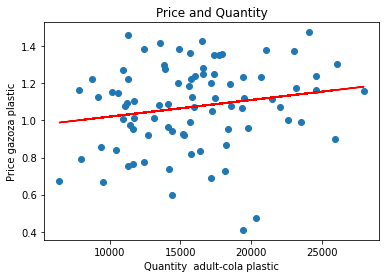

the cross-price-elasticity for gazoza is =0.17819199077580666


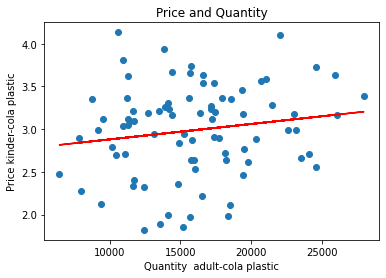

the cross-price-elasticity for kinder-cola is =0.0909081976134235


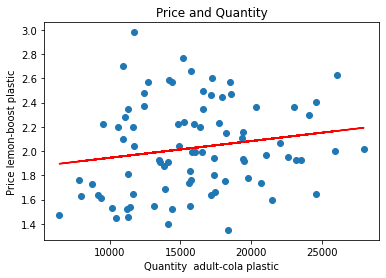

the cross-price-elasticity for lemon-boost is =0.04662474046011142


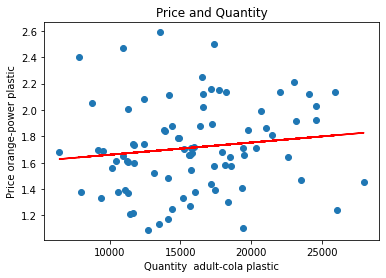

the cross-price-elasticity for orange-power is =0.05720594606496297


In [156]:
cross_price_plot(brand='adult-cola',container='plastic')

## Statistical Significance
NOT COVERED.  SKIP THIS SECTION

In [131]:

Qx = df_city['mean_q']['Athens']['adult-cola']['can'].values.reshape(-1,1) #convert to numpy array using "values"
# define dependent variable Y
Px1 = df_city['mean_p']['Athens']['adult-cola']['can'].values.reshape(-1,1)
Px2 = df_city['mean_p']['Athens']['lemon-boost']['can'].values.reshape(-1,1)
Px = np.concatenate((Px1, Px2), axis=1)

mPx1 = np.mean(Px1)

reg = LinearRegression().fit(Px, Qx)
reg.score(Px, Qx)
P=np.array([[1 ,mPx1]])
Q_hat=reg.predict(P)
Q_hat

import statsmodels.api as sm
mod = sm.OLS(Qx,Px)
fii = mod.fit()
fii.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Ordinary least squares
================================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.889     
Dependent Variable:     y                AIC:                         1776.2149 
Date:                   2022-02-21 23:27 BIC:                         1781.0765 
No. Observations:       84               Log-Likelihood:              -886.11   
Df Model:               2                F-statistic:                 338.9     
Df Residuals:           82               Prob (F-statistic):          2.27e-40  
R-squared (uncentered): 0.892            Scale:                       8.7226e+07
-----------------------------------------------------------------------------------
            Coef.        Std.Err.       t       P>|t|        [0.025        0.975]  
-----------------------------------------------------------------------------------
x1       -13178.5885    6407.0865    -2.0569    0.0429    -25924.3246     -432.8523
x2        62720.6036    7632.5692     8.2175    0.0000     47536.9921    77904.2151
--------------------------------------------------------------------------------
Omnibus:                   2.352             Durbin-Watson:                1.168
Prob(Omnibus):             0.308             Jarque-Bera (JB):             2.085
Skew:                      0.386             Prob(JB):                     0.353
Kurtosis:                  2.967             Condition No.:                8    
================================================================================

"""